# Assignment IHE, Feb. 2024, transient groundwater flow

Prof. dr.ir. T.N. Olsthoorn


Tides in the groundwater of the Amsterdam Water Supply Dunes are investigated.

The data are extracted from a Matlab.mat file that contains the registered groundwater head data of 418 piezometers. The ones with tide are selected as those with piezometer screen below -25 m and with distance to the sea less than 2000. The graphse are shown in this notebook further down. The can be generated with our without subtracting their moving average using scipy.signal.filtfilt().

The amplitudes are computed as the standard deviation divided by 0.7, which is correct for a sin signal.

Delays can be checked by shifting a graphs in time until it best matches the one to be compared with. Dividing by their relative damping before, makes their amplitudes the same, which faclitates the time shift. The time shift $\Delta t$ can be verified as it must match the damping occuring over the difference of the the distance to the sea $L$ between the two piezometers:
$$ s = A e^{-ax} \sin(\omega t - a x)$$
$$ \omega \Delta t = a L $$
$$ \Delta t = \frac{a L}{\omega}$$

The damping factor $a$ is most easily to determine. With its value the time delay can be computed and, therefore, verified by shifting the curves in time accordingly.

In [69]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from scipy.signal import lfilter, filtfilt, find_peaks, find_peaks_cwt
from scipy.interpolate import CubicSpline
from collections.abc import Iterable   # import directly from collections for Python < 3.3

In [82]:
IHE24 = '/Users/Theo/Entiteiten/IHE/IHE2023-2024/'
ASSIGN = os.path.join(IHE24, 'Assignment')
DATA = os.path.join(ASSIGN, 'data')
IMAG = os.path.join(ASSIGN, 'images')

for d in [IHE24, ASSIGN, DATA, IMAG]:
    assert os.path.isdir(d), 'Directory <{}> not found!'.format(d)

In [4]:
def AND(seq):
    """Return logical and of a sequence of logical arrays."""
    L = seq[0]
    for s in seq:
        L = np.logical_and(L, s)
    return L

In [5]:
dtype = np.dtype([('dt', 'datetime64[s]'), ('v', float)])

In [6]:
def gw2rd(GWxy, verbose=False):
    """Return RD coordinates given GW coordinates.

    RD is then Dutch national triangulized coordinates system.
    GW is Gemeentewaterleidingen (Amsterdam Water Supply Dunes system, which is perpendiular
        to the coast line along the Amstedam Water Supply Dunes with zero x at the beach, i.e.
        the distance from the coast.

    Parameters
    ----------
    GWxy: array (n, 2) of floats
        GW coofdinates

    Returns
    -------
    RDxy: np.array (n, 2) of floats
        RD coordinates

    >>>gw2rd(np.array([[61892.94, 885.364]]))
    array([[155000, 463000]])

    See also
    --------
    rd2gw wgs2rd rd2wgs

    @ Pierre Kamps 1999-11-10,
    @ TO 2024-02-10
    """
    assert GWxy.shape[1] == 2, 'RDxy must have shape(n, 2), not {}'.format(shape(RDxy))

    GWaugT = np.ones((3, GWxy.shape[0]))
    GWaugT[:2, :] = GWxy.T

    angle = 22.58378 * np.pi / 180
    xca, yca  =  155000.0, 463000.0
    xrn, yrn  =  -57486.9,  22951.5

    dx, dy = xrn + xca, yrn + yca

    M = np.array([[ np.cos(angle), np.sin(angle), dx],
                  [-np.sin(angle), np.cos(angle), dy],
                  [             0,             0,  1]])
    if verbose:
        print('M = \n', M)
    
    RDxy = (M @ GWaugT).T[:, :2]

    return RDxy


def rd2gw(RDxy, verbose=False):
    """Return GW coordinates given RD coordinates.

    RD is then Dutch national triangulized coordinates system.
    GW is Gemeentewaterleidingen (Amsterdam Water Supply Dunes system, which is perpendiular
        to the coast line along the Amstedam Water Supply Dunes with zero x at the beach, i.e.
        the distance from the coast.

    Parameters
    ----------
    RDxy: array (n, 2) of floats
        RD coofdinates

    Returns
    -------
    GWxy: np.array (n, 2) of floats
        GW coordinates


    >>>rd2gw(np.array([[155000, 463000]]))
    np.array([[61892.94, 885.364]])

    See also
    --------
    gw2rd wgs2rd rd2wgs

    @ Pierre Kamps 1999-11-10, 
    @ TO 2024-02-10
    """
    assert RDxy.shape[1] == 2, 'RDxy must have shape(n, 2), not {}'.format(shape(RDxy))

    RDaugT = np.ones((3, RDxy.shape[0]))
    RDaugT[:2, :] = RDxy.T

    angle = 22.58378 * np.pi / 180
    xca, yca  =  155000.0, 463000.0
    xrn, yrn  =  -57486.9,  22951.5

    dx, dy = xrn + xca, yrn + yca

    M = np.array([[ np.cos(angle), np.sin(angle), dx],
                  [-np.sin(angle), np.cos(angle), dy],
                  [             0,             0,  1]])
    if verbose:
        print('np.linalg.inv(M) = \n', np.linalg.inv(M))
    
    GWxy = (np.linalg.inv(M) @ RDaugT).T[:, :2]

    return GWxy

#gw = np.array([[ 61892.94,    885.364]])
#print(rd2gw(gw2rd(gw)))

#rd = np.array([[155000.04, 463000.000]])
#print(gw2rd(rd2gw(rd)))

In [7]:
def mlDatenum2npDatetime(mlDatenum):
    """Return np.Datenum64(object) from matlab datenum.

    >>>739291.4753587963
    np.datetime64('2023-02-09 11:24:31')
    """
    unix_start_datetime = np.datetime64('1970-01-01')
    unix_start_datenum = 719529
    return (unix_start_datetime
            + (mlDatenum - unix_start_datenum) * 86400 * np.timedelta64(1, 's'))


def npDatetime2mlDatenum(datetime):
    """Return matlab datenum from np.Datenum64 object.

    >>>npDatetime642mlDatenum(np.datetime64('2023-02-09 11:24:31'))
    739291.4753587963
    """
    unix_start_datetime = np.datetime64('1970-01-01')
    unix_start_datenum = 719529
    return ((datetime - unix_start_datetime)
            / np.timedelta64(1, 's') / 86400 + unix_start_datenum)

print(npDatetime2mlDatenum(np.datetime64('2023-02-09 11:24:31')))
print(mlDatenum2npDatetime(738926.4753587963))

# Shorthand
dn2dt = mlDatenum2npDatetime
dt2dn = npDatetime2mlDatenum

738926.4753587963
2023-02-09T11:24:31


In [8]:
def newfig(title, xlabel, ylabel, xscale='linear', yscale='linear',
           xlim=None, ylim=None, figsize=(8, 8)):
    """Return axes to new figure."""
    fig, ax = plt.subplots(1, 1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xscale: ax.set_xscale(xscale)
    if yscale: ax.set_yscale(yscale)
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    if figsize: fig.set_size_inches(figsize)
    ax.grid(True)
    return ax
        

### We can read any mat file using scipy.io.loadmat function.

# Read Divers_Leiduin.mat using mat file using scipy.io.loadmat(f)

In [9]:
HOME = '/Users/Theo/GRWMODELS/AWD/PeilData/'
f = os.path.join(HOME, 'Divers_Leiduin.mat')

In [10]:
# Load the matlab mat file with the data
diversLDN = loadmat(f)

### All relevant piezometer data are under key 'H'

In [11]:
diversLDN.keys()

dict_keys(['__header__', '__version__', '__globals__', 'H', 'IN', 'M', 'B', 'T', 'ID', 'VER'])

In [128]:
# Put the piezometer data in a dictionary for easier access
print("Number of piezometers in diversLDN['H'] = {}".format(len(diversLDN['H'])))

pbuis = dict()
for item in diversLDN['H']:
    data = item[0]
    name = data[1][0]
    pbuis[name] = {
        'id': data[0][0][0], # index in file (no meaning)
        'name': name,        # piezometer(nest) name with screen index
        'values': data[3],   # array of [[matlabDatenum, head]]
        'xRD': data[5][0][0], # x coordinate, Dutch coordinate system
        'yRD': data[6][0][0], # y coordinate
        'bkf': data[7][0][0], # top of of piezometer screen
        'okf': data[8][0][0], # bottom of piezometer screen
        'mv': data[9][0][0],  # ground surface elevation
        }

Number of piezometers in diversLDN['H'] = 418


# Well info to DataFrame

In [17]:
# Generate a DataFrame (table) with meta data for the piezomters
columns = ['name', 'xRD', 'yRD', 'xGW', 'yGW', 'dist2sea', 'screenNAP', 'tmin', 'tmax']

def r(v):
    """Return value rounded to to decimals."""
    return np.round(v, 2)

# Generate a list first and add the local coordinates xGW and yGW (coordinates // to coast)
pbcoords = list()
for name in pbuis:
    p = pbuis[name]
    xRD, yRD = p['xRD'], p['yRD']
    RDxy = np.array([[xRD, yRD]])
    xGW, yGW = rd2gw(np.array([[xRD, yRD]]))[0]
    xGW_beach = -2000
    dist2sea = xGW - xGW_beach
    screenNAP = p['okf']
    t = mlDatenum2npDatetime(p['values'][:, 0])
    tmin, tmax = t[0], t[-1]
    pbcoords.append([name, r(xRD), r(yRD), r(xGW), r(yGW), r(dist2sea), screenNAP, tmin, tmax]) 

# Convert meta data to DataFrame
pbMeta = pd.DataFrame(data=pbcoords, columns=columns, index=[n for n in pbuis]).drop(columns=['name'])
pbMeta

,xRD,yRD,xGW,yGW,dist2sea,screenNAP,tmin,tmax
10J009.1,99493.79,486211.68,1728.89,1000.88,3728.89,1.2,1999-06-22 11:00:00,2014-03-28 08:00:00
10J011.1,99908.68,485762.30,2284.54,745.29,4284.54,-1.5,2012-04-12 15:00:00,2014-04-07 11:00:00
10J040.1,93129.85,478540.11,-1200.91,-8526.39,799.09,-2.1,2006-11-10 14:00:00,2014-03-03 12:00:00
10J042.1,96433.14,481935.91,544.98,-4122.41,2544.98,-1.9,2009-02-05 20:00:00,2014-04-04 06:59:59
10J044.1,94377.21,479091.10,-260.80,-7538.63,1739.20,-3.1,2006-11-10 14:00:00,2014-03-13 12:00:00
...,...,...,...,...,...,...,...,...
P147.1,96460.84,482232.75,456.56,-3837.70,2456.56,-0.5,2009-02-05 20:00:00,2011-03-30 09:59:59
P152.1,96027.09,484475.52,-805.23,-1933.48,1194.77,-0.5,2002-04-25 15:59:59,2014-03-18 08:00:00
P153.1,95172.20,482282.33,-752.31,-4286.80,1247.69,-0.5,2002-04-25 15:59:59,2014-03-17 12:59:59
P154.1,95536.88,482650.29,-556.91,-3807.00,1443.09,-0.5,2002-11-19 18:00:00,2014-03-17 12:59:59


# Sort out wells for use in tide analysis

In [18]:
# Use L to select piezometers
L = AND([pbMeta['xGW'] > 1500,
         pbMeta['yGW'] < 2500,
         pbMeta['yGW'] <= -4500,
         pbMeta['yGW'] >= -60000])

# List the selected piezometers
pbMeta[L]

,xRD,yRD,xGW,yGW,dist2sea,screenNAP,tmin,tmax
10J094.1,97130.11,480052.62,1911.75,-5593.63,3911.75,-2.8,2004-03-02 18:00:00,2014-04-04 09:00:00
10J095.1,96946.08,480181.37,1692.39,-5545.43,3692.39,-2,2004-03-02 18:00:00,2014-04-04 09:00:00
10J522.1,97850.06,480512.91,2399.72,-4892.15,4399.72,-5.14,1996-03-15 18:00:00,2005-11-01 12:59:59
10J526.1,97890.00,480410.00,2476.12,-4971.83,4476.12,-1.5,1997-07-10 15:00:00,2002-08-01 09:59:59
10J527.1,97817.99,480469.05,2386.96,-4944.96,4386.96,-6.12,1997-07-10 15:00:00,2002-08-01 09:59:59
10J534.1,97436.98,480925.45,1859.89,-4669.88,3859.89,-8.7,1999-04-16 10:44:59,2000-02-09 09:59:59
10J534.2,97436.98,480925.45,1859.89,-4669.88,3859.89,-4.2,1999-03-01 15:14:59,1999-05-31 09:30:00
24H076.4,97373.34,480597.71,1926.99,-4996.93,3926.99,-85,1997-08-28 03:59:59,1999-02-14 23:00:00
24H076.6,97373.34,480597.71,1926.99,-4996.93,3926.99,-34,1996-08-07 18:00:00,2014-04-08 00:00:00
24H076.7,97373.34,480597.71,1926.99,-4996.93,3926.99,-5,1996-01-19 18:00:00,2014-04-08 00:00:00


# Tides in Groundwater

First get the piezometers that are likely to show the tide in their heads. These are those that have their screen below -25 m and are within 2000 m from the beach.

In [29]:
tlim = np.datetime64('2013-04-01'), np.datetime64('2013-06-01')
tlim = np.datetime64('2013-05-08'), np.datetime64('2013-05-15')

L = AND([pbMeta['dist2sea'] > 0, pbMeta['dist2sea'] < 2000,
         pbMeta['screenNAP'] <= -25, pbMeta['screenNAP'] >= -50,
         pbMeta['tmax'] > np.datetime64(tlim[0])])

pbMeta[L].sort_values(by=['dist2sea', 'yGW'])

,xRD,yRD,xGW,yGW,dist2sea,screenNAP,tmin,tmax
24H258.5,93920.94,482025.21,-1808.88,-5004.73,191.12,-37.6,2006-11-08 12:00:00,2014-03-27 12:59:59
24H287.5,95149.24,484862.09,-1764.23,-1913.68,235.77,-36.6,2006-11-08 09:59:59,2014-03-27 09:59:59
24H461.5,93301.09,480237.97,-1694.84,-6892.97,305.16,-26.6,2007-03-29 11:00:00,2014-01-05 00:00:00
24H465.4,94843.07,483815.08,-1644.83,-2997.98,355.17,-34.5,1995-05-29 16:15:00,2014-04-08 00:00:00
24H464.5,94482.59,482912.61,-1631.09,-3969.68,368.91,-34.2,1995-05-29 16:44:59,2014-04-08 00:00:00
24H095.1,93497.23,480025.45,-1432.12,-7013.86,567.88,-40,2007-02-20 12:00:00,2014-03-03 09:59:59
24H284.1,95493.86,484737.36,-1398.13,-1896.50,601.87,-27.8,2004-01-21 18:00:00,2014-03-18 08:00:00
24H087.1,94015.90,480930.18,-1300.67,-5979.32,699.33,-38.5,1995-11-16 15:59:59,2014-03-04 12:59:59
24H075.1,94451.76,481949.20,-1289.57,-4871.06,710.43,-39.9,1996-04-19 18:00:00,2014-03-04 09:59:59
24H542.6,93324.60,478963.02,-1183.51,-8061.12,816.49,-29.2,1999-04-13 12:59:59,2014-03-03 11:00:00


In [124]:
def showpBuizen(pbuis, pzNames=None, tlim=None, ylim=None, verbose=None, fflen=None):
    """Show the piezomers, possibly subtract a moving mean using filtfilt.

    Parameters
    ----------
    fflen: int | None
        length of the filter to be applied by scipy.signal.filtfilt
        to subtract a moving mean
    """

    pzMissing = [nm for nm in pzNames if nm not in pbuis]
    for pz in pzMissing:
        print("{} not in pbuis dataset!".format(pzMissing))

    # Continue with the rest
    pzNames = [nm for nm in pzNames if nm in pbuis]
    
    fig, axs = plt.subplots(len(pzNames), 1, sharex=True)
    fig.set_size_inches(12, len(pzNames) * 4)

    if isinstance(axs, Iterable):
        pass
    else:
        axs = [axs]

    assert tlim is not None, "tlim must not be None but (tstart, tend) both np.datetime64)"
            
    for i, name in enumerate(pzNames):
        pb = pbuis[name]
        xRD, yRD = pb['xRD'], pb['yRD']
        xGW, yGw = rd2gw(np.array([[xRD, yRD]]))[0]
        toSea = xGW + 2000.
        
        axs[i].set_title(
            """pz. {} zscr={:.2f} mNAP sea={:.0f} m yGW={:.0f} m""".format(name, pb['okf'], toSea, yGw))
        
        axs[i].set_ylabel('h [mNAP]')
        if name == pzNames[-1]:
            axs[i].set_xlabel('Date')
            
        axs[i].grid(True)
        axs[i].set_xlim(tlim)        

        tml = pb['values'][:, 0]
        tnp = dn2dt(tml)
        h = pb['values'][:, 1]

        if fflen is not None:
            assert isinstance(fflen, int), 'fflen must be None or int (filtfilt length).'
            b = np.ones(fflen) / fflen
            h -= filtfilt(b, 1, h)

        if ylim is None:
            m = np.round(h.mean(), 2)
            hstd = h.std()
            axs[i].set_ylim(m - 2 * hstd, m + 3 * hstd)
        else:
            ylim=ylim

        ampl = hstd / 0.5 # true for pure sine
        ampl_sea = 0.92 # m
        axs[i].plot(tnp, h, label='{}, ampl={:.3f} m, a/a_sea = {:.3f}'.format(name, ampl, ampl / ampl_sea))
        
        axs[i].legend(loc='best')

    fig.savefig("pbuis" + pzNames[0][:-2] + ".png")
        
    plt.show()
    return


Not all selected piezometers did show tide. Therefore, the ones without sufficient tide were excluded from further analysis (see `notide` list).

Make a new dict `tideBuis` with just the tide-holding piezometers and add a number of essential paramters to them.

In [143]:
notide = ['24H245.5', '24H453.5', '24H288.1', '24H377.1', '24H464.5', '24H540.4']

# These do show a nice tide
pztide_names = sorted(set(pbMeta[L].index).difference(notide))

# Sort the set with ascending xGW
pbt = list()
for name in pztide_names:
    xGW, yGW = rd2gw(np.array([[pbuis[name]['xRD'], pbuis[name]['yRD']]]))[0]
    pbt.append((xGW + 2000, yGW, name))
pbt = sorted(pbt)
pztide_names = [n[-1] for n in pbt]

tideBuis = dict()
b = np.ones(60) / 60
for name in pztide_names:
    pb = pbuis[name]
    xRD, yRD = pb['xRD'], pb['yRD']
    xGW, yGW = rd2gw(np.array([[xRD, yRD]]))[0]
    xGW, yGW = np.round(xGW, 1), np.round(yGW, 1)    
    toSea = xGW + 2000
    tml = pb['values'][:, 0]
    tnp = dn2dt(tml)
    h = pb['values'][:, 1]
    hff = h - filtfilt(b, 1, h)
    amp = hff.std() / 0.7
    tideBuis[name] = pbuis[name].copy()
    tb = tideBuis[name]
    tb.update(xGW=xGW, yGW=yGW, toSea=toSea, tml=tml, tnp=tnp,
              h=np.round(h, 3), hff=np.round(hff, 3), amp=np.round(amp, 3))
    

In [144]:
tideBuis[pztide_names[-1]].keys()
tideBuis[pztide_names[-1]]


{'id': 198,
 'name': '24H451.5',
 'values': array([[ 7.29567792e+05, -1.01474547e-18],
        [ 7.29567875e+05,  1.52496069e-02],
        [ 7.29567958e+05,  2.55673835e-02],
        ...,
        [ 7.35691375e+05,  1.53503143e-03],
        [ 7.35691417e+05,  3.77109390e-03],
        [ 7.35691458e+05, -6.77626358e-20]]),
 'xRD': 93951.39,
 'yRD': 478456.01999999984,
 'bkf': -32.9,
 'okf': -33.9,
 'mv': 4.14,
 'xGW': -410.1,
 'yGW': -8288.5,
 'toSea': 1589.9,
 'tml': array([729567.79166667, 729567.875     , 729567.95833333, ...,
        735691.375     , 735691.41666667, 735691.45833333]),
 'tnp': array(['1997-06-26T18:59:59', '1997-06-26T21:00:00',
        '1997-06-26T23:00:00', ..., '2014-04-02T09:00:00',
        '2014-04-02T09:59:59', '2014-04-02T11:00:00'],
       dtype='datetime64[s]'),
 'h': array([-0.   ,  0.015,  0.026, ...,  0.002,  0.004, -0.   ]),
 'hff': array([ 0.   ,  0.015,  0.025, ...,  0.002,  0.004, -0.   ]),
 'amp': 0.028}

Plot the piezometer data with tide but subtract their moving average to more easily to compare them and compute their amplitude as std / 0.7 (true for sine-waves). The computed amplitudes are in the legend label.

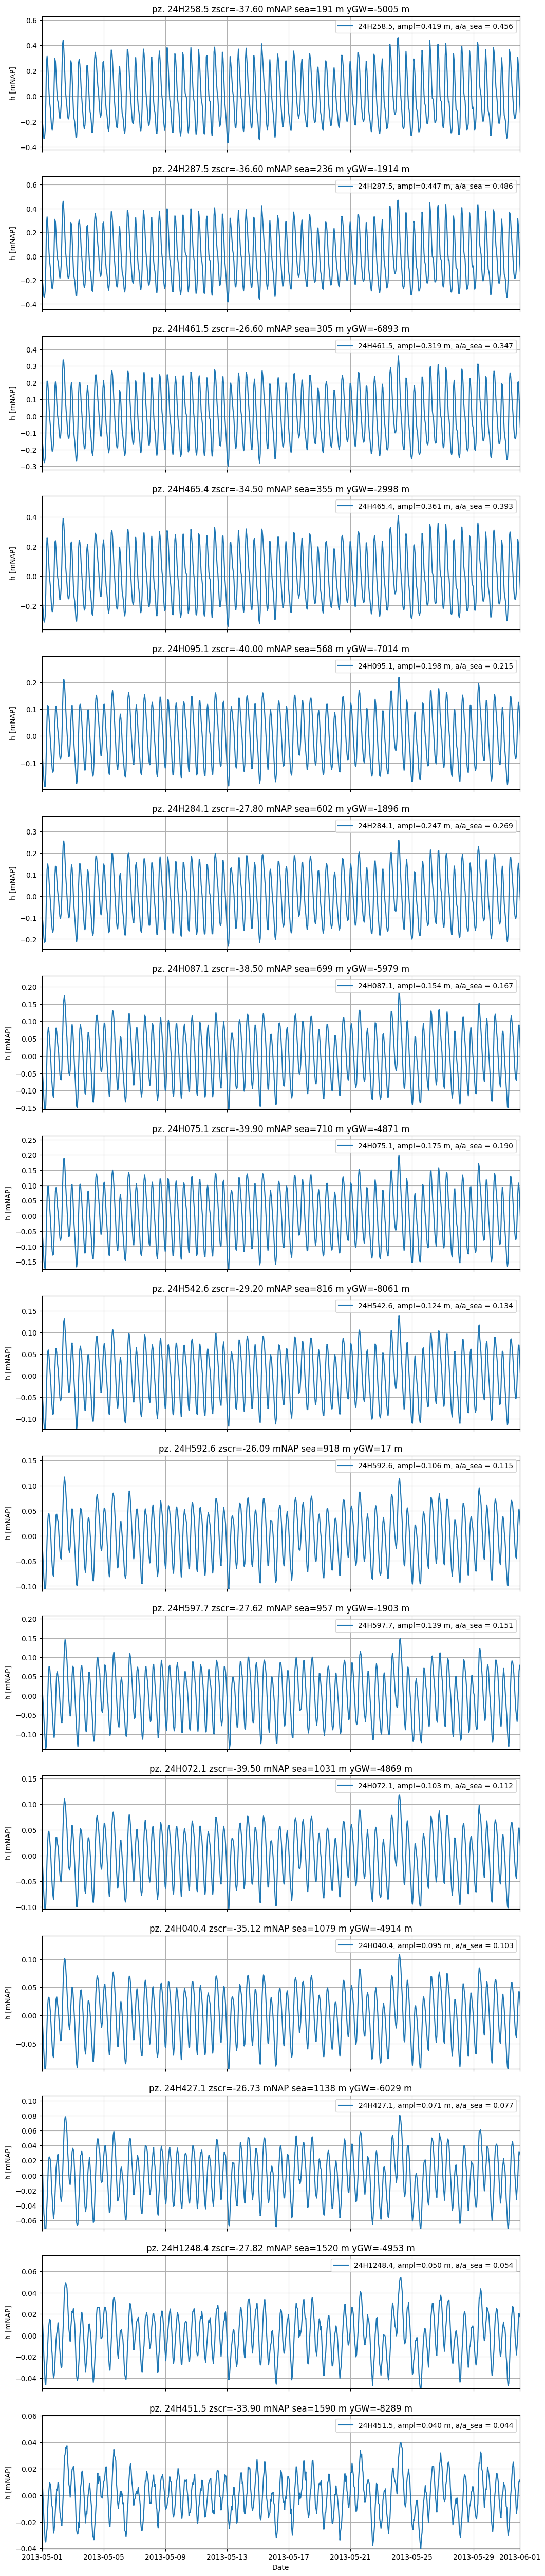

In [132]:
tlim = np.datetime64('2013-04-01'), np.datetime64('2013-06-01')
tlim = np.datetime64('2013-05-08'), np.datetime64('2013-05-15')
tlim = np.datetime64('2013-05-01'), np.datetime64('2013-06-01')
showpBuizen(tideBuis, pzNames=tideBuis.keys(), tlim=tlim, fflen=60)

# Show the tide in the North Sea

## Curently we only have the data for Hoek of Holland

In [84]:
fname = 'Grondwt.csv'
pth = os.path.join(DATA, fname)
assert os.path.isfile(pth), "Can't open file {}".format(pth)

In [85]:
usecols = ['datum tijd', 'waarde', 'rks_xcrdgs', 'rks_ycrdgs',
           'tydehd', 'tydstp', 'rks_begdat', 'loccod', 'loc_xcrdgs', 'loc_ycrdgs', 'rks_begtyd', 'rks_enddat', 'rks_endtyd']
usecols = ['datum tijd', 'waarde', 'loccod', 'loc_xcrdgs', 'loc_ycrdgs']

data_all = pd.read_csv(pth, header=0, sep=';', usecols=usecols, index_col='datum tijd', parse_dates=True, dayfirst=True)

In [93]:
tideHVH = data_all.loc[data_all['loccod'] == 'HOEKVHLD'].copy()
tideHVH.loc[tideHVH['waarde'] > 1000, 'waarde'] = np.nan
tideHVH.loc[:, 'waarde'] /= 100. # to m

#tideIJM = data_all.loc[data_all['loccod'] == 'IJMDBNN'].copy()
#tideIJM['waarde'][tideIJM['waarde'] > 1000] = np.nan
#tideIJM['waarde'] /= 100. # to m

print(tideHVH)
#print()
#print(tideIJM)

                       loccod  loc_xcrdgs  loc_ycrdgs  waarde
datum tijd                                                   
2013-05-01 00:00:00  HOEKVHLD     6793000    44400000   -1.08
2013-05-01 00:10:00  HOEKVHLD     6793000    44400000   -1.04
2013-05-01 00:20:00  HOEKVHLD     6793000    44400000   -1.00
2013-05-01 00:30:00  HOEKVHLD     6793000    44400000   -0.96
2013-05-01 00:40:00  HOEKVHLD     6793000    44400000   -0.93
...                       ...         ...         ...     ...
2013-05-31 23:10:00  HOEKVHLD     6793000    44400000   -0.05
2013-05-31 23:20:00  HOEKVHLD     6793000    44400000   -0.16
2013-05-31 23:30:00  HOEKVHLD     6793000    44400000   -0.24
2013-05-31 23:40:00  HOEKVHLD     6793000    44400000   -0.34
2013-05-31 23:50:00  HOEKVHLD     6793000    44400000   -0.43

[4464 rows x 4 columns]


In [ ]:
tideHVH.loc[np.logical_and(tideHVH.index >= tlim[0], tideHVH.index <= tlim[1])]

ax = newfig('Tide in HVH', 'Date', 'mNAP')

n = 225
b = np.ones(n) / n # moving avarea for n/6 hours (10 minute data)

h = tideHVH['waarde'] - filtfilt(b, 1, tideHVH['waarde'], padlen=None)

ax.plot(tideHVH.index, h, label='{}, ampl={:.3f} m'.format(tideHVH.iloc[0]['loccod'], h.std() / 0.7))
ax.legend()

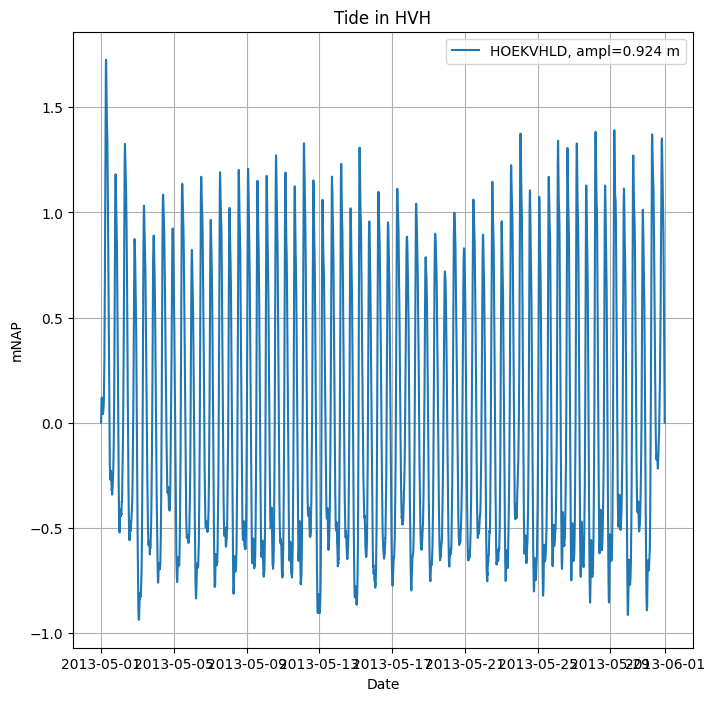

In [ ]:
xRD = tijdHVH[iloc[0, 'loc_xcrdgs']
yRD = tijdHVH[iloc[0, 'loc_ycrdgs']
xGW, yGW = rd2gw(np.array([[xRD, yRD]]))[0]
tnp = tijdHVH
tidePbuis['hoekvh'].update(xRD=xRD, yRD=yRD, xGW=xGW, yGW=yGW, toSea=xGW + 2000, tml=tml, tnp=tnp,
              h=np.round(h, 3), hff=np.round(hff, 3), amp=np.round(amp, 3))
    
.update(xRD=, yRD=, xGW= yGW=, toSea=0.0, tml=, tnp=, h=, hff=, amp=